This notebook uses data scraped from the churchofjesuschrist.org website with ASL language general conference talks.

In [0]:
# !curl -o gc.zip https://students.cs.byu.edu/~kac1995/2000.zip

In [1]:
"""
  1. Mount Google Drive (no need to check if already mounted, it does that for you)
  2. 
"""
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!rm -rf "/content/gc"
!unzip "/content/gdrive/My Drive/CS474 Final Project/GC/2000.zip" > /dev/null
!mv "/content/users/guest/k/kac1995/dev/CS474-General-Conference-Downloader/gc" "/content/gc"

In [0]:
# root directory has a structure like "year/month/talk/[video|text]"
root_dir = "/content/gc"

In [4]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm
!sudo apt install libavdevice-dev libavfilter-dev > /dev/null # Required to get av to install
!pip3 install av # Required for torchvision to work with videos.
!pip install torchtext spacy
!python -m spacy download en



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
     |████████████████████████████████| 2.0MB 5.4MB/s 
  Created wheel for av: filename=av-6.2.0-cp36-cp36m-linux_x86_64.whl size=4975769 sha256=7803b7ae4d30019ba0bc2f10076b05de26f8855a904b2c638393a5ab0a83849b
  Stored in directory: /root/.cache/pip/wheels/2f/c1/b2/05e83d944cde5df317e4542082d67756ec4224c7885aee2d66
Successfully built av
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-pa

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, datasets
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import torchtext
import spacy
import gc
import os
import math
import av
import re
from IPython.core.ultratb import AutoFormattedTB
from torch.utils.data.sampler import SubsetRandomSampler

__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [0]:
# !ls "/content/gc/2000/04"
test_file = "/content/gc/2000/04/are-you-still-here/frames.mp4"
vid, audio, meta = torchvision.io.video.read_video(test_file, pts_unit="sec")

In [10]:
meta

{'video_fps': 10.0}

In [0]:
sample_minutes = 1
fps = 10
sample_frames = sample_minutes * 60 * fps

text_replacements = {
    # end of paragraphs that may not have been done correctly
    '\.([^ ])': ". \\1",
    "\!([^ ])": "! \\1",
    "\?([^ ])": "? \\1",
    "\:([^ ])": ": \\1",
    
    # Some unicode chars that I know of
    u"\u201c": '"',
    u"\u201d": '"',
    u"\u2018": "'",
    u"\u2019": "'",
    "  +": " "
}

class GeneralConferenceDataset(Dataset):
  def __init__(self, root=root_dir, video_file="frames.mp4", text_file="text.txt", frames_per_item=sample_frames):
    self.root_dir = root
    self.video_file = video_file
    self.text_file = text_file
    self.frames_per_item = frames_per_item
    self.years = self._discover_folders(root_dir)
    self.months = self._discover_folders(self.years)
    self.talks = self._discover_folders(self.months)
    self.tokenizer = spacy.load('en').tokenizer
    self.transforms = torchvision.transforms.Compose([
        torchvision.transforms.Lambda(lambda img: img.transpose(0, 2)),
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize(224),                
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor()
    ])

  def _discover_folders(self, parent):
    if type(parent) != list: # we're gonna flatten lists, so this makes that easier
      parent = [parent]
    return [os.path.join(p, d.name) for p in parent for d in os.scandir(p) if d.is_dir()]

  def _load_text(self, talk_dir, video_frames):
    """
    Loads the text in the given talk as a list of word2vec vectors.

    However, it does this by assuming that the temporal length is best measured by the number of word pieces, not the number of characters or english words
    This is an assumption that we'll need to revisit in the future.
    """
    with open(os.path.join(talk_dir, self.text_file), 'r') as f:
      talk_text = f.read().lower()

      # Because of the way that I downloaded the data, we need to separate sentences and replace crappy apostrophes.
      for key in text_replacements:
        talk_text = re.sub(key, text_replacements[key], talk_text)
      
      tokens = self.tokenizer(talk_text)
      num_tokens = len(tokens)
      desired_length = math.ceil((self.frames_per_item / video_frames) * num_tokens)
      start_token = random.randint(0, num_tokens - desired_length)

      token_sample = tokens[start_token:start_token + desired_length]
      return token_sample

  def __getitem__(self, index):
    """
      Returns a random sample of the video at index, and the text we hope that it represents.
    """
    # Load the video and get a sample of the frames. Video is of size [num_frames, h, w, c]
    talk_dir = self.talks[index]
    video, _, meta = torchvision.io.video.read_video(os.path.join(talk_dir, self.video_file), pts_unit="sec")
    num_frames = video.size(0)
    length = self.frames_per_item
    start_frame = random.randint( 0, num_frames - length )
    frame_sample = video[start_frame:start_frame + length]

    # Apply some transforms to the frames (but the same transform for every frame in video)
    frame_sample = torch.stack([self.transforms(i) for i in frame_sample])

    # Now get a chunk of text of hopefully comparable spot.
    text_sample = self._load_text(talk_dir, num_frames)
    return frame_sample, text_sample

    def __len__(self):
      return len(self.talks)

In [0]:
dataset = GeneralConferenceDataset()

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((2, 1, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [0]:
# An example of a piece of text. F is the frames.
f, t = dataset[0]
# f.size()
# imshow(f[0])

In [69]:
f.size()

torch.Size([600, 3, 224, 224])

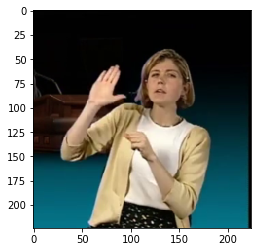

In [70]:
f1 = f[100]
imshow(f1)

In [0]:
class GeneralConferenceModel(nn.Module):
  def __init__(self):
    super(GeneralConferenceModel, self).__init__()
    self.feature_extracter = # Resnet
    self.net = nn.LSTM() # Parameters should be tweaked, probably

  def forward(self, frames):
    # Extract features
    
    pass